# Predict RL via HM

Lukas Graz  
July 10, 2025

## Setup + Preprocessing

In [ ]:
suppressPackageStartupMessages({
  library(dplyr)
  library(ggplot2)
  library(egg)
  library(kernlab)
  library(mgcv)  # for GAM models - smoothing
  library(gridExtra)  # for combining plots
  library(tidyr)  # for pivoting data
})


Number of matches per filter criteria (not disjoint)
  Headphone  PRS_all_NA    Distance Activity_NA    Duration  HMNoise_NA 
        303         226         221         102          96          96 
JourneyTime 
         20 
Keep  1494 of 2206 observations

Imputing PRS_orig_vars

In [ ]:
D$RL_NDVI     <- pmax(0, D$RL_NDVI)
D_trn$RL_NDVI <- pmax(0, D_trn$RL_NDVI)
D_tst$RL_NDVI <- pmax(0, D_tst$RL_NDVI)

D$LANG <- as.factor(D$LANG)
D_trn$LANG <- as.factor(D_trn$LANG)
D_tst$LANG <- as.factor(D_tst$LANG)

D$SEX <- as.factor(D$SEX)
D_trn$SEX <- as.factor(D_trn$SEX)
D_tst$SEX <- as.factor(D_tst$SEX)

D$JNYTIME <- D$JNYTIME + quantile(D$JNYTIME[D$JNYTIME > 0], 0.05, na.rm=TRUE)/2
D_trn$JNYTIME <- D_trn$JNYTIME + quantile(D_trn$JNYTIME[D_trn$JNYTIME > 0], 0.05, na.rm=TRUE)/2
D_tst$JNYTIME <- D_tst$JNYTIME + quantile(D_tst$JNYTIME[D_tst$JNYTIME > 0], 0.05, na.rm=TRUE)/2

D$DISTKM <- D$DISTKM + quantile(D$DISTKM[D$DISTKM > 0], 0.05, na.rm=TRUE)/2
D_trn$DISTKM <- D_trn$DISTKM + quantile(D_trn$DISTKM[D_trn$DISTKM > 0], 0.05, na.rm=TRUE)/2
D_tst$DISTKM <- D_tst$DISTKM + quantile(D_tst$DISTKM[D_tst$DISTKM > 0], 0.05, na.rm=TRUE)/2


D$SPEED_log <- log(D$DISTKM / D$JNYTIME)
D_trn$SPEED_log <- log(D_trn$DISTKM / D_trn$JNYTIME)
D_tst$SPEED_log <- log(D_tst$DISTKM / D_tst$JNYTIME)


# logical_vars <- c("ALONE","WITH_DOG","WITH_KID","WITH_PAR","WITH_PNT","WITH_FND")
# D[logical_vars] <- lapply(D[logical_vars], as.numeric)
# D_trn[logical_vars] <- lapply(D_trn[logical_vars], as.numeric)
# D_tst[logical_vars] <- lapply(D_tst[logical_vars], as.numeric)


In [ ]:
nams <- names(D)
nams[grep("HM|RL", nams)]


 [1] "HM_NOISELVL" "HM_NDVI"     "HM_NOISE"    "RL_NDVI"     "RL_NOISE"   
 [6] "HM_COORDX"   "HM_COORDY"   "RL_COORDX"   "RL_COORDY"   "RL_GCOORD"  
[11] "RL_GCOORDN"  "RL_GCOORDW" 

In [ ]:
cor(cbind(D_trn[c("DISTKM_sqrt", "JNYTIME_sqrt", "SPEED_log")]))


             DISTKM_sqrt JNYTIME_sqrt SPEED_log
DISTKM_sqrt        1.000       0.4894    0.7145
JNYTIME_sqrt       0.489       1.0000   -0.0835
SPEED_log          0.715      -0.0835    1.0000

Remove DIST_sqrt, as it is highly correlated with the other two.

## RL_NDVI

In [ ]:
lm_ndvi <- lm(RL_NDVI ~ (HM_NDVI + HM_NOISE + 
  #  ALONE + WITH_DOG + WITH_KID + WITH_PAR + WITH_PNT + WITH_FND +
   LANG + AGE + SEX +
   SPEED_log + JNYTIME_sqrt)^2, D_trn)
step_ndvi <- step(lm_ndvi, trace = FALSE, k = log(nrow(D_trn)))
summary(fit <- lm(formula(step_ndvi), D_tst))



Call:
lm(formula = formula(step_ndvi), data = D_tst)

Residuals:
   Min     1Q Median     3Q    Max 
-3.371 -0.430  0.182  0.698  1.989 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)        -0.1690     0.0946   -1.79  0.07452 .  
HM_NDVI             0.1581     0.0413    3.83  0.00015 ***
LANGGerman          0.2232     0.1064    2.10  0.03633 *  
LANGItalian         0.0028     0.1965    0.01  0.98866    
SPEED_log          -0.0720     0.0414   -1.74  0.08277 .  
JNYTIME_sqrt        0.1272     0.0415    3.07  0.00226 ** 
HM_NDVI:SPEED_log  -0.1848     0.0422   -4.38  1.4e-05 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.958 on 536 degrees of freedom
Multiple R-squared:  0.0917,    Adjusted R-squared:  0.0815 
F-statistic: 9.02 on 6 and 536 DF,  p-value: 2.09e-09

-   R² = 0.08
-   Higher HM_NDVI corresponds to slightly higher RL-NDVI
-   higher JNYTIME_sqrt corresponds to slightly higher RL-NDVI
-   The faster (or further) you travel to RL, the more the RL_NDVI differs from HM_NDVI (negative interaction effect)

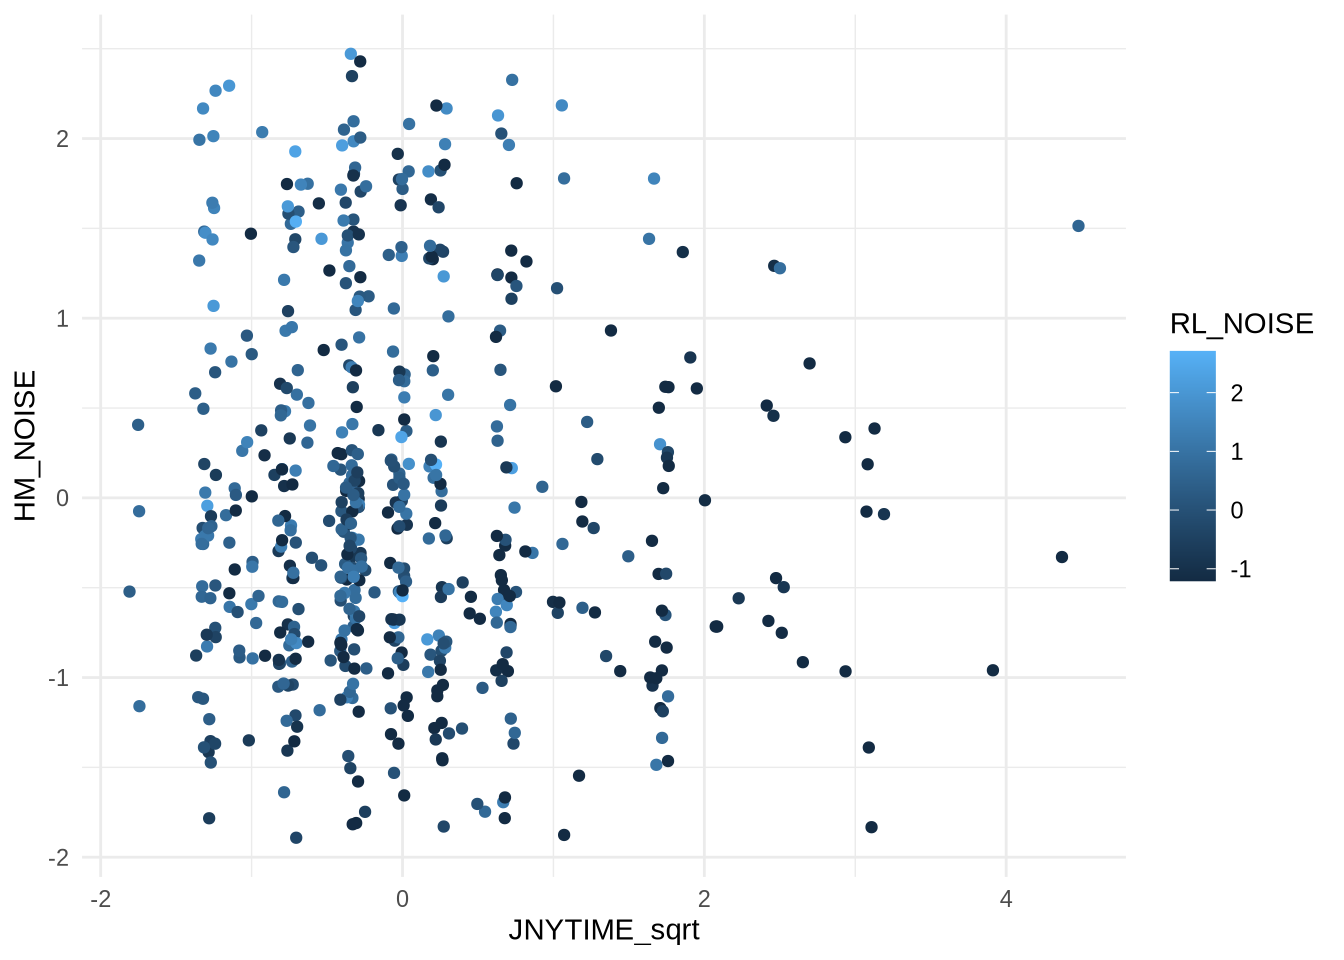

In [ ]:
ggplot(D_tst, aes(x = JNYTIME_sqrt, y=HM_NOISE, col = RL_NOISE)) +
  geom_jitter(width=0.07, height = 0.1)


## RL_NOISE

In [ ]:
lm_noise <- lm(RL_NOISE ~ (HM_NDVI + HM_NOISE + 
  #  ALONE + WITH_DOG + WITH_KID + WITH_PAR + WITH_PNT + WITH_FND +
   LANG + AGE + SEX +
   SPEED_log + JNYTIME_sqrt)^2, D_trn)
step_noise <- step(lm_noise, trace = FALSE, k = log(nrow(D_trn)))
summary(lm(formula(step_noise), D_tst))



Call:
lm(formula = formula(step_noise), data = D_tst)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.5097 -0.7495 -0.0467  0.6473  2.8683 

Coefficients:
                      Estimate Std. Error t value Pr(>|t|)    
(Intercept)           -0.03379    0.08896   -0.38  0.70426    
HM_NOISE               0.23846    0.03916    6.09  2.2e-09 ***
LANGGerman            -0.00494    0.09968   -0.05  0.96047    
LANGItalian            0.62198    0.18667    3.33  0.00092 ***
SPEED_log             -0.06326    0.03902   -1.62  0.10552    
JNYTIME_sqrt          -0.31956    0.03936   -8.12  3.2e-15 ***
HM_NOISE:JNYTIME_sqrt -0.03423    0.04070   -0.84  0.40061    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.904 on 536 degrees of freedom
Multiple R-squared:  0.193, Adjusted R-squared:  0.184 
F-statistic: 21.3 on 6 and 536 DF,  p-value: <2e-16

-   R² = 0.184
-   Participants can’t completely escape HM_NOISE (HM_NOISE positive predictor)
-   LANGItalians have it louder (than LANG de/fr)
-   Longer JNYTIME_sqrt leads to lower NOISE

In [ ]:

# Fit Gaussian Process
X <- as.matrix(D_tst[, c("JNYTIME_sqrt", "HM_NOISE")])
y <- D_tst$RL_NOISE

# Fit GP with RBF kernel
gp_model <- gausspr(X, y, kernel = "rbfdot", kpar = "automatic")


Using automatic sigma estimation (sigest) for RBF or laplace kernel 

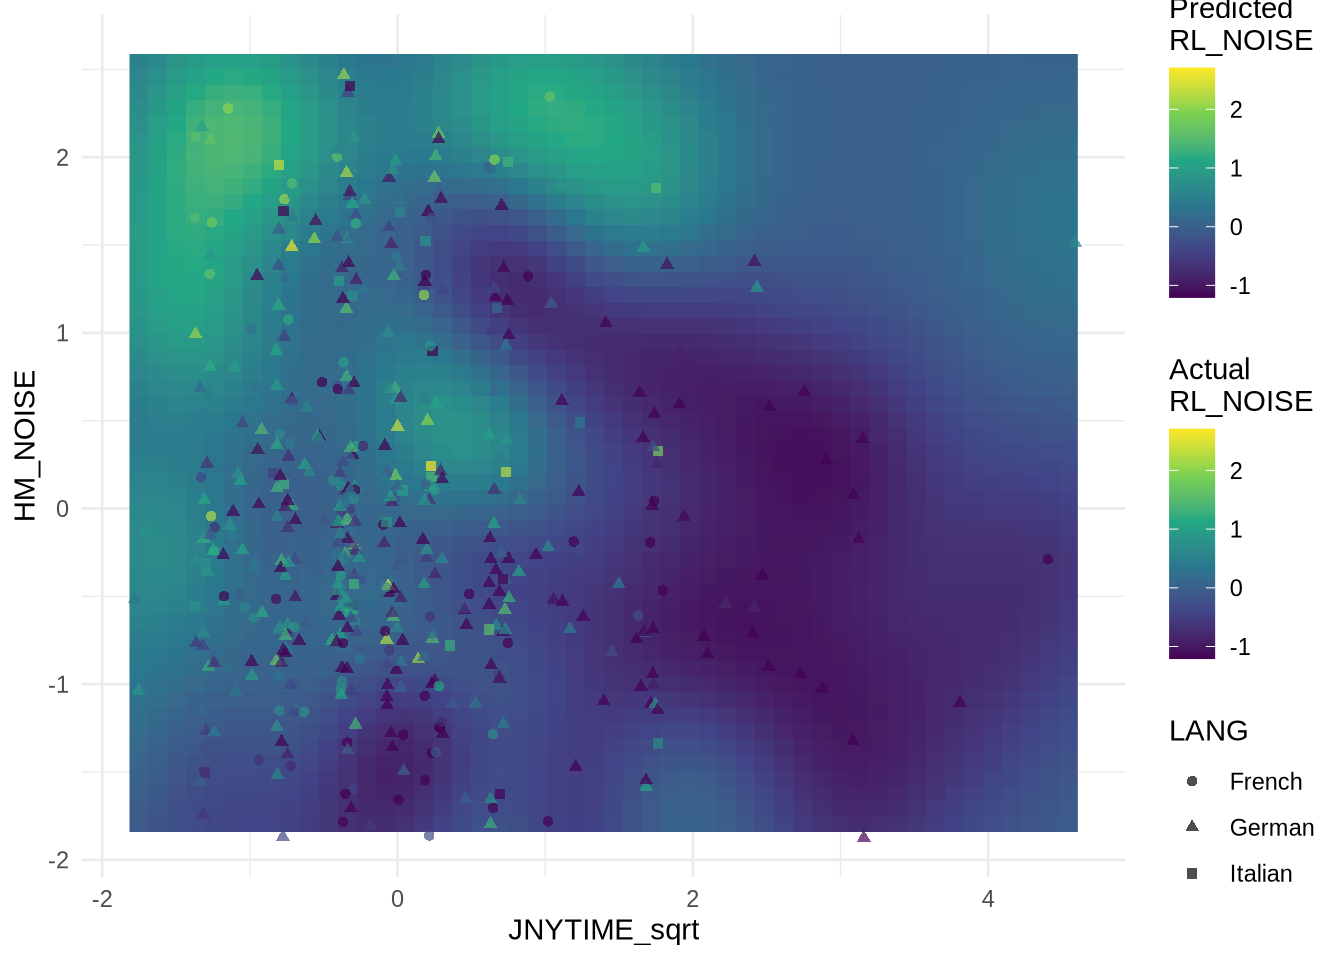

In [ ]:

# Plot with matching color scales
ggplot() +
  geom_raster(data = grid, aes(x = JNYTIME_sqrt, y = HM_NOISE, fill = predicted_RL_NOISE)) +
  geom_jitter(data = D_tst, aes(x = JNYTIME_sqrt, y = HM_NOISE, col = RL_NOISE, shape = LANG), 
              width = 0.07, height = 0.1, alpha = 0.7) +
  scale_fill_viridis_c(name = "Predicted\nRL_NOISE", limits = combined_range) +
  scale_color_viridis_c(name = "Actual\nRL_NOISE", limits = combined_range) 


In [ ]:
D$PRS <- rowMeans(cbind(D$FA,D$BA,D$EC,D$ES))
summary_fun <- function(x) c(mean = mean(x, na.rm = TRUE), 
                              sd = sd(x, na.rm = TRUE), 
                              median = median(x, na.rm = TRUE))

aggregate(PRS~ HM_NOISELVL, D, summary_fun)


  HM_NOISELVL PRS.mean PRS.sd PRS.median
1           1    4.989  0.886      5.000
2           2    4.928  0.915      4.917
3           3    4.857  0.926      4.833

  HM_NOISELVL FA.mean FA.sd FA.median
1           1    5.25  1.10      5.33
2           2    5.16  1.21      5.21
3           3    5.18  1.13      5.33

  HM_NOISELVL BA.mean BA.sd BA.median
1           1    5.11  1.20      5.00
2           2    5.04  1.17      5.00
3           3    4.95  1.20      5.00

  HM_NOISELVL EC.mean EC.sd EC.median
1           1    4.53  1.31      4.33
2           2    4.48  1.34      4.33
3           3    4.47  1.29      4.33

  HM_NOISELVL ES.mean ES.sd ES.median
1           1    5.07  1.42      5.19
2           2    5.04  1.38      5.00
3           3    4.83  1.55      5.00